# Wavelet transform based image template matching for automatic component inspection
This notebook implements DWT template matching method, proposed by Cho, HJ., Park, TH. Implemented by Cherniaev Egor, Bc. (2024)

*Cho, HJ., Park, TH. Wavelet transform based image template matching for automatic component inspection. Int J Adv Manuf Technol 50, 1033–1039 (2010). https://doi.org/10.1007/s00170-010-2567-9*

## Setup

In [10]:
import cv2
import numpy as np
from skimage.io import imshow

In [7]:
im_0 = cv2.cvtColor(cv2.imread("../assets/simulation/6d59ebb2-0f98-4d18-bed4-1eb127b113ed.png"), cv2.COLOR_BGR2GRAY)
im_1 = cv2.cvtColor(cv2.imread("../assets/simulation/8c0788e4-2149-4284-8642-d1c41b6298ce.png"), cv2.COLOR_BGR2GRAY)

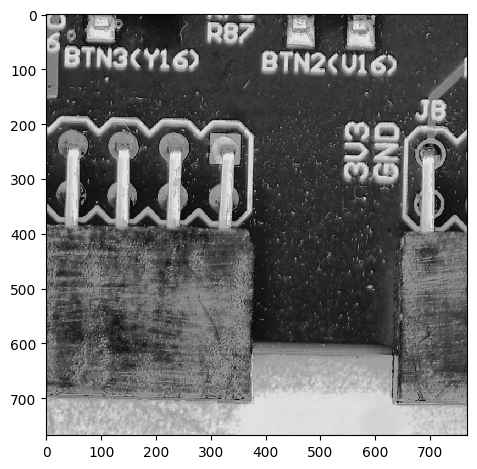

In [158]:
imshow(im_0)

## Implementation

In [31]:
# TODO: It is possible to combine functions (vertical and horizontal) and pass required axis to calculate along
# TODO: There should exist matrix based calculation to do this faster

def iter_average_h(im: np.ndarray):  
    # Eq. 3
    r, c  = im.shape[0], im.shape[1]
    assert c % 2 == 0

    res = np.zeros((r, int(c/2)))
    for i in range(int(c/2)):
        res[:, i] = (im[:, 2*i-1] + im[:, 2*i])/2
    
    return res


def iter_difference_h(im: np.ndarray):
    # Eq. 4. It seems that there is an error in indexes (I assume that logic is the same as in eq. 6-9).
    r, c  = im.shape[0], im.shape[1]
    assert c % 2 == 0

    res = np.zeros((r, int(c/2)))
    for i in range(int(c/2)):
        res[:, i] = (im[:, 2*i] - im[:, 2*i-1])/2
    
    return res

/home/egor/anaconda3/envs/vut-dp/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


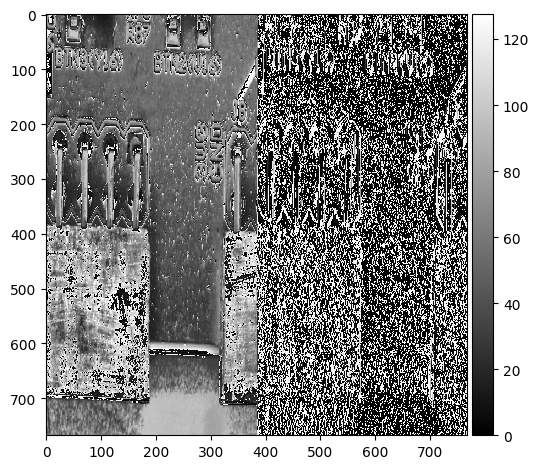

In [29]:
imshow(np.column_stack([iter_average_h(im_0), iter_difference_h(im_0)]), cmap='grey')

In [32]:
def iter_average_v(im: np.ndarray):  
    # Eq. 6, 7
    r, c  = im.shape[0], im.shape[1]
    assert r % 2 == 0

    res = np.zeros((int(r/2), c))
    for i in range(int(r/2)):
        res[i, :] = (im[2*i-1, :] + im[2*i, :])/2
    
    return res


def iter_difference_v(im: np.ndarray):
    # Eq. 8, 9
    r, c  = im.shape[0], im.shape[1]
    assert r % 2 == 0

    res = np.zeros((int(r/2), c))
    for i in range(int(r/2)):
        res[i, :] = (im[2*i, :] - im[2*i-1, :])/2
    
    return res

In [49]:
def dwt(im: np.ndarray, n=1):
    for i in range(n):
        s = iter_average_h(im)
        d = iter_difference_h(im)

        ul = iter_average_v(s)
        ur = iter_average_v(d)
        ll = iter_difference_v(s)
        lr = iter_difference_v(d)

        im = ul
    
    return ul, ur, ll, lr

def show_dwt(ul: np.ndarray, ur: np.ndarray, ll: np.ndarray, lr: np.ndarray):
    imshow(
        np.row_stack([
            np.column_stack([ul, ur]),
            np.column_stack([ll, lr])
        ]), cmap='grey')

There were no comments on used number of iterations in the paper (n)

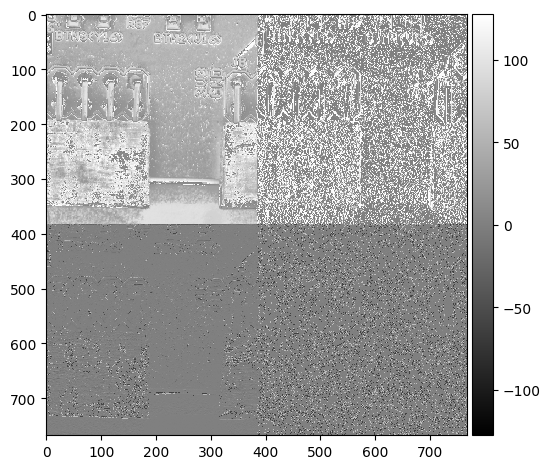

In [154]:
ul, ur, ll, lr = dwt(im_1, n=1)
show_dwt(ul, ur, ll, lr)

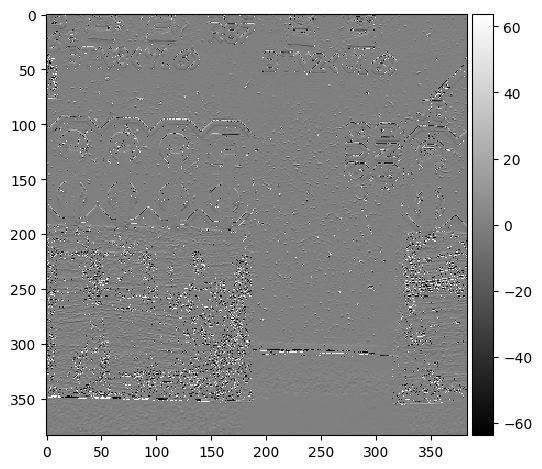

In [155]:
imshow(ll, cmap='grey')

## Segmentation
I assume that there is an error in the paper - lower left element is marked as C^LR (should be C^LL according to context).

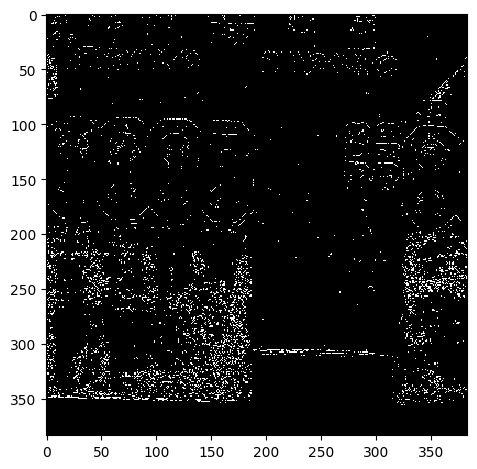

In [157]:
# Eq. 11, 12
c_min = np.min(ll)
c_max = np.max(ll)

# Eq. 13
c = (np.copy(ll) - c_min)/(c_max - c_min)*256

# Eq. 14
# There was no comments on threshold (t) value in paper (lower, upper)
tl = 0.2 * 256
tu = 0.8 * 256
c[(c <= tl) | (c >= tu)] = 1
c[(c > tl) & (c < tu)] = 0

imshow(c)